<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-setup-functions" data-toc-modified-id="Imports-and-setup-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and setup functions</a></span></li><li><span><a href="#Load-satellite-data-into-PyTorch" data-toc-modified-id="Load-satellite-data-into-PyTorch-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load satellite data into PyTorch</a></span><ul class="toc-item"><li><span><a href="#Train-val-test-split" data-toc-modified-id="Train-val-test-split-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Train-val-test split</a></span></li><li><span><a href="#Testing-ERA5-data-download" data-toc-modified-id="Testing-ERA5-data-download-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Testing ERA5 data download</a></span></li></ul></li><li><span><a href="#Download-CIFAR10-data" data-toc-modified-id="Download-CIFAR10-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Download CIFAR10 data</a></span></li><li><span><a href="#Define-small-CNN" data-toc-modified-id="Define-small-CNN-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define small CNN</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test</a></span></li></ul></div>

# Imports and setup functions

In [71]:
import os
import math
import datetime

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc

In [34]:
def datadir(x):
    return "/home/lucia/projects/FORMES/rainfall-pde-ml/data/" + x

# Load satellite data into PyTorch

## Train-val-test split

The authors trained on SST data from 2006-2015 and tested on data from 2016-2017. For the IBI reanalysis SST data, we only have from June 5, 2021 to June 23, 2023 (748 days). From these, we will use 80% for training, 10% for validation, and 10% for testing. 

In [110]:
def train_val_test_cutoffs(topdir, split):
    
    all_files = os.listdir(topdir)
    all_files.sort()
    nfiles = len(all_files)
    
    start_date = datetime.datetime.strptime(all_files[0][8:-3], "%Y%m%d").date()
    end_date = datetime.datetime.strptime(all_files[nfiles-1][8:-3], "%Y%m%d").date()
    
    cutoffs = []
    
    for i in range(3):
        delta = math.floor(nfiles*split[i])
        end = start_date + datetime.timedelta(days=delta)
        cutoffs.append(end)
        
        start_date = end
        
    # Because of rounding, some files may have been missed
    # Add these to the test split
    if cutoffs[2] < end_date:
        cutoffs[2] = end_date
    
    return cutoffs

In [121]:
def train_val_test_split_files(topdir, split):
    assert len(split) == 3, "Please include a % split for train, validation, and test sets."
    
    cutoffs = train_val_test_cutoffs(topdir, split)
    
    all_files = os.listdir(topdir)
    all_files.sort()
    
    train, val, test = [], [], []
    
    for f in all_files:
        file_date = datetime.datetime.strptime(f[8:-3], "%Y%m%d").date()
        
        if file_date <= cutoffs[0]:
            train.append(f)
        elif (file_date > cutoffs[0]) & (file_date <= cutoffs[1]):
            val.append(f)
        else:
            test.append(f)
            
    return train, val, test

In [ ]:
def create_tensor(nc_obj, var):
    # TODO:
    # 1. run train_val_test_split_files to get filename splits
    # 2. for each file in the split, load the numpy masked array
    # 3. create a torch.masked Tensor using the data and mask
    # 4. output the 
    
    ncd = nc_obj[var]
    data = ncd.data
    mask = ncd.mask
    
    return masked_tensor(data, mask)

def get_data_and_ends(files):
    

def get_training_data(topdir, split):
    train_files = train_val_test_split_files(topdir, split)[0]
    

    # TODO: train inputs & train ends!!
    # inputs: days 0-597
    # ends: days 1-598
    
    # TODO: nc.MFDataset?

In [125]:
files_split = train_val_test_split_files(datadir("cdo_out/"), [.8, .1, .1])

In [127]:
torch.tensor(nc.Dataset(datadir("cdo_out/sst_geo_20210605.nc"))["thetao"][:])

tensor([[[[20.0710, 20.0930, 20.1200,  ..., 19.7470, 19.7450, 19.7350],
          [19.8140, 19.8410, 19.8760,  ..., 19.7390, 19.7330, 19.7180],
          [19.6350, 19.6460, 19.6630,  ..., 19.7290, 19.7190, 19.6990],
          ...,
          [11.2440, 11.2460, 11.2460,  ..., 11.6980, 11.6850, 11.6790],
          [11.2450, 11.2470, 11.2480,  ..., 11.6820, 11.6780, 11.6790],
          [11.2390, 11.2420, 11.2460,  ..., 11.6880, 11.6960, 11.7070]]]])

In [ ]:
# Notes
# 1. To use an equivalent of masked arrays in PyTorch, use torch.masked - masked Tensor
#    a. To create, need the data array as a Tensor and the mask as another Tensor

In [5]:
class SatelliteDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.img_dir))
    
    def __getitem__(self, date):
        for f in os.listdir(self.img_dir):
            if f.contains(date):
                return f

In [17]:
SD = SatelliteDataset(datadir("/home/lucia/projects/FORMES/rainfall-pde-ml/data/cdo_out"))

data_loader = DataLoader(SD, batch_size=64, shuffle=False)

In [20]:
SD.data.shape

AttributeError: 'SatelliteDataset' object has no attribute 'data'

In [21]:
type(SD)

__main__.SatelliteDataset

## Testing ERA5 data download

In [15]:
import netCDF4 as nc

test = nc.Dataset("/home/lucia/projects/FORMES/rainfall-pde-ml/data/ERA5/adaptor.mars.internal-1688681470.3379288-4932-6-1074ff60-6824-44e6-a39d-781f83d30d6d.nc")

In [16]:
test.variables

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (21,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (65,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:00.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: 
 current shape = (17544,)
 filling on, default _FillValue of -2147483647 used,
 'u10': <class 'netCDF4._netCDF4.Variable'>
 int16 u10(time, latitude, longitude)
     scale_factor: 0.00026573851851714974
     add_offset: 0.8716170086704289
     _FillValue: -32767
     missing_value: -32767
     units: m s**-1
     long_name: 10 metre U wind 

In [31]:
import pandas as pd
temp = pd.DataFrame(test["t2m"][:].reshape(17544,-1))
temp.shape, type(temp)

((17544, 1365), pandas.core.frame.DataFrame)

In [32]:
temp.resample(24).mean()

ValueError: Invalid frequency: 24

# Download CIFAR10 data

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), 
                                                     (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0.0%

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


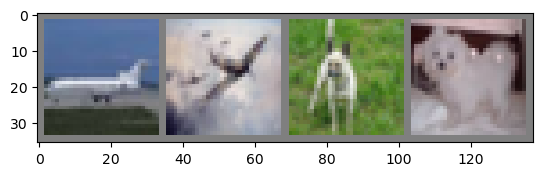

plane plane cat   dog  


In [7]:
# Function to display images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Define small CNN

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
net = Net()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training

In [14]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.204
[1,  4000] loss: 1.873
[1,  6000] loss: 1.653
[1,  8000] loss: 1.568
[1, 10000] loss: 1.536
[1, 12000] loss: 1.449
[2,  2000] loss: 1.415
[2,  4000] loss: 1.359
[2,  6000] loss: 1.325
[2,  8000] loss: 1.303
[2, 10000] loss: 1.300
[2, 12000] loss: 1.274
Finished Training


# Test

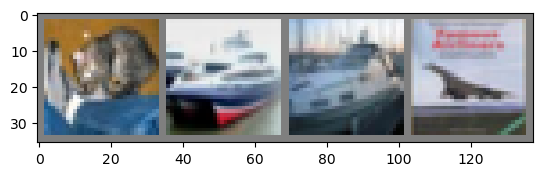

GroundTruth:  cat   ship  ship  plane


In [15]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [16]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  car   plane


In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 57.8 %
Accuracy for class: car   is 80.9 %
Accuracy for class: bird  is 52.5 %
Accuracy for class: cat   is 40.1 %
Accuracy for class: deer  is 39.9 %
Accuracy for class: dog   is 44.8 %
Accuracy for class: frog  is 67.5 %
Accuracy for class: horse is 58.7 %
Accuracy for class: ship  is 63.0 %
Accuracy for class: truck is 56.6 %


In [ ]:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.3803